# Notebook for LST1 training and storage of Random Forests 


## Some imports

In [1]:
import numpy as np                                                                                            
import pandas as pd                                                                                                                                                                                      
import matplotlib.pyplot as plt                                                                               
import joblib  

from lstchain.reco.dl1_to_dl2 import train_energy, train_disp_vector, train_sep, apply_models  
from lstchain.visualization import plot_dl2     
from lstchain.reco import utils, disp

from sklearn.model_selection import train_test_split
from lstchain.tests.test_lstchain import dl1_params_lstcam_key
from lstchain.io.config import get_standard_config

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

/Users/rlopezcoto/opt/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get event DL1 files for training

    
We need two files, for **gammas** and for **protons**. These gammas are pointlike.

In [3]:
gammafile = "../../data/mc/dl1/gamma-diffuse/dl1_gamma_20deg_180deg_run99___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.h5"
protonfile = "../../data/mc/dl1/proton/dl1_proton_20deg_180deg_run99___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5"

<font size="4">
We read the files as pandas dataframes:

In [4]:
# reading events

df_gammas = pd.read_hdf(gammafile, key=dl1_params_lstcam_key)                                                               
df_proton = pd.read_hdf(protonfile, key=dl1_params_lstcam_key)

# Filtering events

config = get_standard_config()
events_filters = config["events_filters"]
df_gammas = utils.filter_events(df_gammas, filters=events_filters, 
                                finite_params=config['regression_features'] + config['classification_features'])
df_proton = utils.filter_events(df_proton, filters=events_filters,
                               finite_params=config['regression_features'] + config['classification_features'])

    
df_gammas.keys()

Data contains not-predictable events.
Column | Number of non finite values
log_intensity : 21
phi : 21
kurtosis : 21
length : 21
psi : 21
y : 21
wl : 21
r : 21
time_gradient : 30
leakage_intensity_width_2 : 21
x : 21
skewness : 21
width : 21
Data contains not-predictable events.
Column | Number of non finite values
log_intensity : 9
phi : 9
kurtosis : 9
length : 9
psi : 9
y : 9
wl : 9
r : 9
time_gradient : 11
leakage_intensity_width_2 : 9
x : 9
skewness : 9
width : 9


Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'width', 'psi', 'skewness', 'kurtosis',
       'time_gradient', 'intercept', 'leakage_intensity_width_1',
       'leakage_intensity_width_2', 'leakage_pixels_width_1',
       'leakage_pixels_width_2', 'n_pixels', 'concentration_cog',
       'concentration_core', 'concentration_pixel', 'n_islands',
       'calibration_id', 'mc_energy', 'log_mc_energy', 'mc_alt', 'mc_az',
       'mc_core_x', 'mc_core_y', 'mc_h_first_int', 'mc_type', 'mc_az_tel',
       'mc_alt_tel', 'mc_x_max', 'mc_core_distance', 'wl', 'tel_id',
       'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type', 'disp_dx',
       'disp_dy', 'disp_norm', 'disp_angle', 'disp_sign', 'src_x', 'src_y'],
      dtype='object')

<font size="4">
From all the previous information, we choose certain features to train the Random Forests. We choose the standard ones.

In [5]:
features = config['regression_features']
features 

['log_intensity',
 'width',
 'length',
 'x',
 'y',
 'psi',
 'phi',
 'wl',
 'skewness',
 'kurtosis',
 'r',
 'time_gradient',
 'leakage_intensity_width_2']

<font size="4">
Now we must split the data into train and test sets. 
Gamma events will train energy and direction reconstruction, and gamma/hadron separation, but protons are only used for separation.


## Train the Reconstruction


We train two Random Forest Regressors, from scikit-learn, to reconstruct "energy" and "disp" of the **test** set.

In [6]:
#Train regressors for energy and disp_norm reconstruction, ONLY with gammas

RFreg_Energy = train_energy(df_gammas)

RFreg_Disp = train_disp_vector(df_gammas)


#Train classifier for gamma/hadron separation.
traing, testg = train_test_split(df_gammas, test_size=0.2)

temp_reg_energy = train_energy(traing)
temp_reg_disp_vector = train_disp_vector(traing)

Given features:  ['log_intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 'skewness', 'kurtosis', 'r', 'time_gradient', 'leakage_intensity_width_2']
Number of events for training:  3797
Training Random Forest Regressor for Energy Reconstruction...
Model <class 'sklearn.ensemble._forest.RandomForestRegressor'> trained!
Given features:  ['log_intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 'skewness', 'kurtosis', 'r', 'time_gradient', 'leakage_intensity_width_2']
Number of events for training:  3797
Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> for disp vector regression
Model <class 'sklearn.ensemble._forest.RandomForestRegressor'> trained!
Given features:  ['log_intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 'skewness', 'kurtosis', 'r', 'time_gradient', 'leakage_intensity_width_2']
Number of events for training:  3037
Training Random Forest Regressor for Energy Reconstruction...
Model <class 'sklearn.ensemble._forest.Random


We can now predict the **energy** and **disp** of the test events, and from **disp**, calculate the reconstructed direction.

In [7]:

test = testg.append(df_proton,ignore_index=True)            #Protons are only for testing when trainin Energy/Direction reco.


#Apply the regressors to the test set

test['log_reco_energy'] = temp_reg_energy.predict(test[features])  
test['reco_energy'] = np.power(10,test['log_reco_energy']) 

disp_vector = temp_reg_disp_vector.predict(test[features])                                                  
test['reco_disp_dx'] = pd.DataFrame(disp_vector[:,0])
test['reco_disp_dy'] = pd.DataFrame(disp_vector[:,1])


In [8]:
test['reco_src_x'],test['reco_src_y'] = disp.disp_to_pos(test.reco_disp_dx,
                                                            test.reco_disp_dy,
                                                            test.x,
                                                            test.y,
                                                            )

We use these test events with reconstructed energy and direction to 
    **train the gamma/hadron separation.**
<br>
We add these two features to the list of features for training:

In [9]:
features_sep = list(features)                                                                             
features_sep.append('log_reco_energy') 
features_sep.append('reco_disp_dx')
features_sep.append('reco_disp_dy')
features_sep

['log_intensity',
 'width',
 'length',
 'x',
 'y',
 'psi',
 'phi',
 'wl',
 'skewness',
 'kurtosis',
 'r',
 'time_gradient',
 'leakage_intensity_width_2',
 'log_reco_energy',
 'reco_disp_dx',
 'reco_disp_dy']

In [10]:
test.keys()

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'width', 'psi', 'skewness', 'kurtosis',
       'time_gradient', 'intercept', 'leakage_intensity_width_1',
       'leakage_intensity_width_2', 'leakage_pixels_width_1',
       'leakage_pixels_width_2', 'n_pixels', 'concentration_cog',
       'concentration_core', 'concentration_pixel', 'n_islands',
       'calibration_id', 'mc_energy', 'log_mc_energy', 'mc_alt', 'mc_az',
       'mc_core_x', 'mc_core_y', 'mc_h_first_int', 'mc_type', 'mc_az_tel',
       'mc_alt_tel', 'mc_x_max', 'mc_core_distance', 'wl', 'tel_id',
       'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type', 'disp_dx',
       'disp_dy', 'disp_norm', 'disp_angle', 'disp_sign', 'src_x', 'src_y',
       'log_reco_energy', 'reco_energy', 'reco_disp_dx', 'reco_disp_dy',
       'reco_src_x', 'reco_src_y'],
      dtype='object')


**Train the gamma/hadron classifier:**
<br>
Now we train a scikit-learn **RandomForestClassifier** which will separate events in two classes: 0 for **gammas** and 1 for **protons**. We call this parameter **hadroness**.


In [11]:
#Train the Classifier
RFcls_GH = train_sep(test)


Given features:  ['log_intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 'skewness', 'kurtosis', 'r', 'time_gradient', 'leakage_intensity_width_2', 'log_reco_energy', 'reco_disp_dx', 'reco_disp_dy']
Number of events for training:  1935
Training Random Forest Classifier for Gamma/Hadron separation...
Random Forest trained!


<font size="4">
Predict the hadroness of the test events:

In [12]:
test['reco_type'] = RFcls_GH.predict(test[features_sep])

In [13]:
test['gammaness'] = 1 - test['reco_type'] 

## Save the Random Forests:
<br>
We can save these trained RF into files to apply them later on any set of data:

In [14]:
fileE = "RFreg_Energy.sav"                                                           
fileD = "RFreg_Disp.sav"                                                             
fileH = "RFcls_GH.sav"                                                               
joblib.dump(RFreg_Energy, fileE)                                                                      
joblib.dump(RFreg_Disp, fileD)                                                                        
joblib.dump(RFcls_GH, fileH)

['RFcls_GH.sav']


# Now we can plot some results
<br>
We can take in input the corresponding testing sample from the same RF folder. 
If we apply the RF, we can get the test_dl2 file

In [16]:

gammafile_test = "../../data/mc/dl1/gamma/dl1_gamma_south_pointing_20201017_v0.6.3_prod5_LST1_local_off0.0deg_DL1_testing.h5"
df_gammas_test = pd.read_hdf(gammafile_test, key=dl1_params_lstcam_key)                                                               
df_gammas_test = utils.filter_events(df_gammas_test, filters=events_filters,
                                    finite_params=config['regression_features'] + config['classification_features'])

test_dl2 = apply_models(df_gammas_test, RFcls_GH, RFreg_Energy, RFreg_Disp)


Data contains not-predictable events.
Column | Number of non finite values
log_intensity : 7442
phi : 7442
kurtosis : 7442
length : 7442
psi : 7442
y : 7442
wl : 7442
r : 7442
time_gradient : 8962
leakage_intensity_width_2 : 7442
x : 7442
skewness : 7442
width : 7442
/Users/rlopezcoto/opt/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:46: MissingFrameAttributeWarning: AltAz coordinate has no obstime, assuming same frame
  MissingFrameAttributeWarning,
/Users/rlopezcoto/opt/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:54: MissingFrameAttributeWarning: Horizontal coordinate has no location, assuming same frame
  MissingFrameAttributeWarning,


### Distribution of features

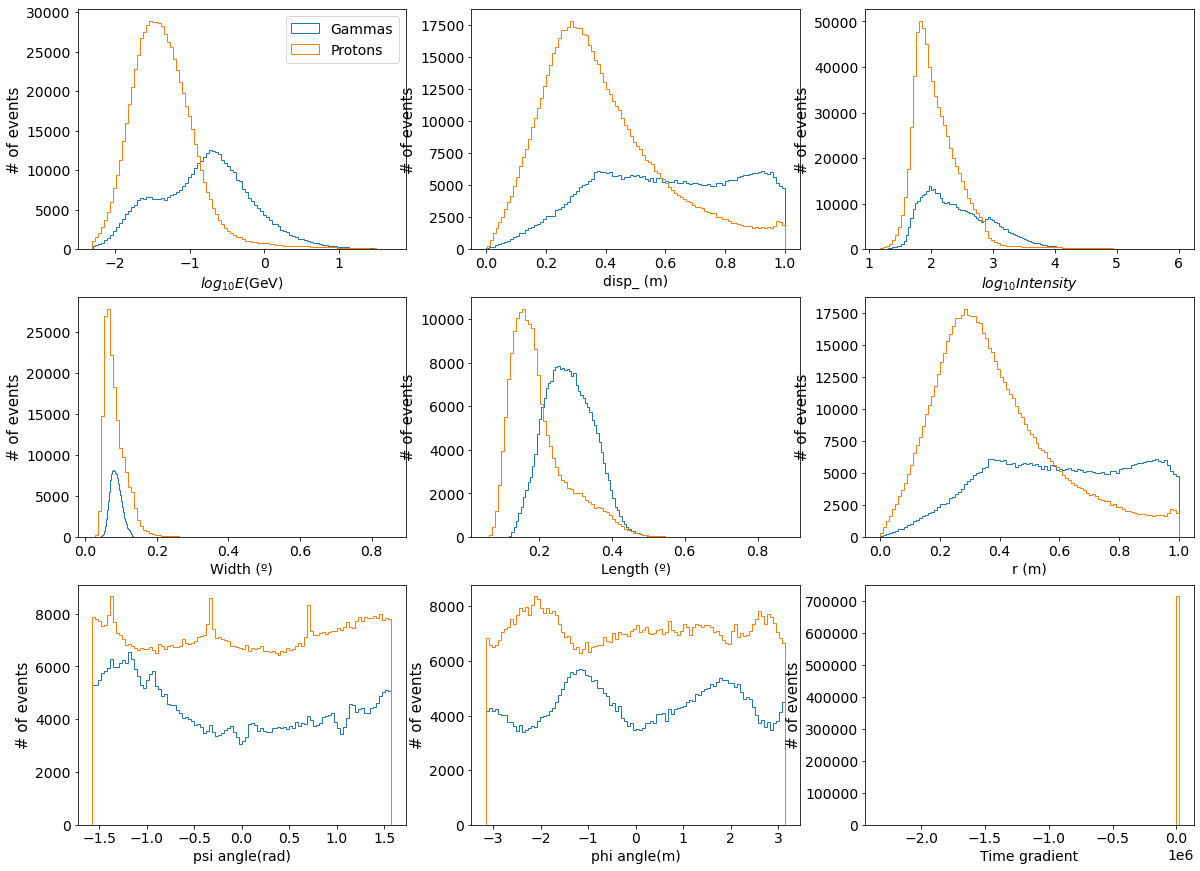

In [17]:
plot_dl2.plot_features(test_dl2)

## Energy reconstruction

<AxesSubplot:title={'center':'Energy resolution'}, xlabel='$E_R$ [TeV]', ylabel='$(\\Delta E/E)_{68}$'>

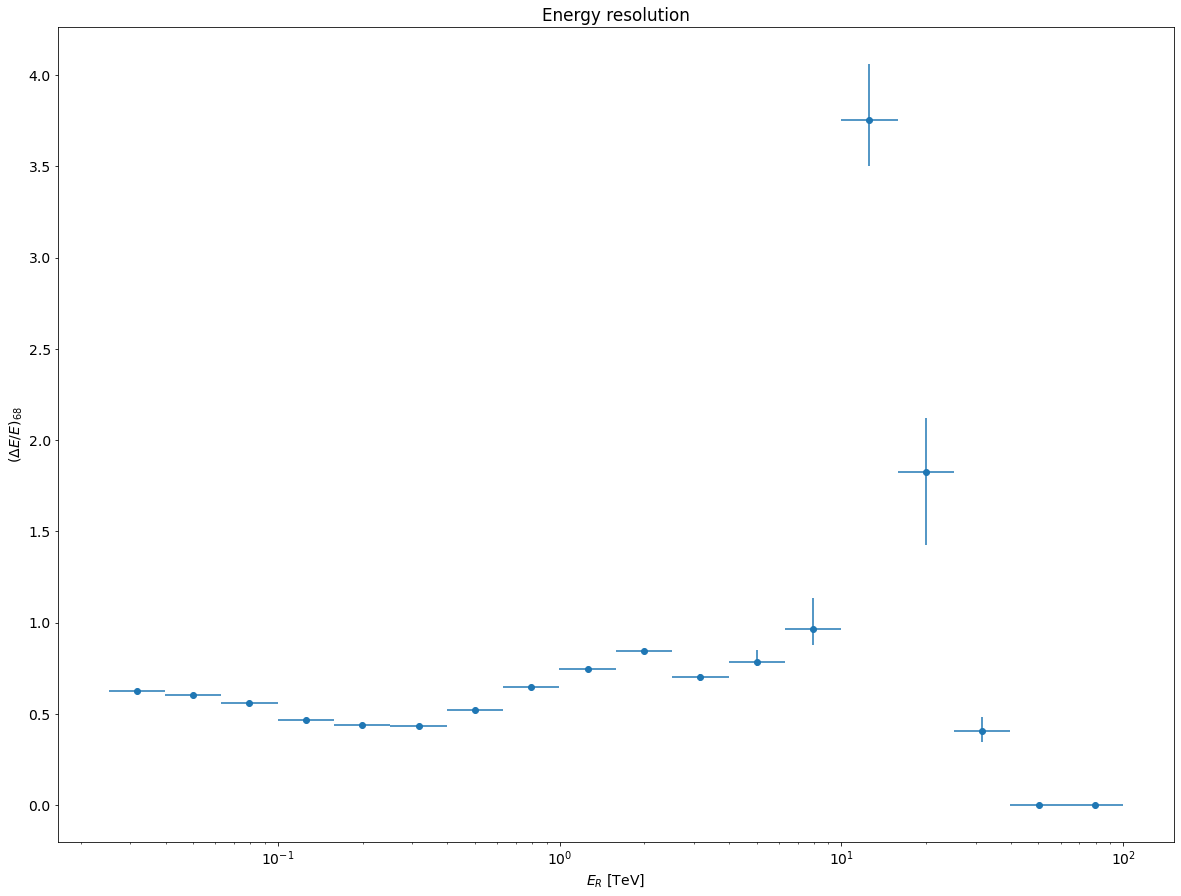

In [18]:
plot_dl2.plot_energy_resolution(test_dl2)

## Disp reconstruction

mu = 0.046748438079496676
 sigma = 0.21411165943954064


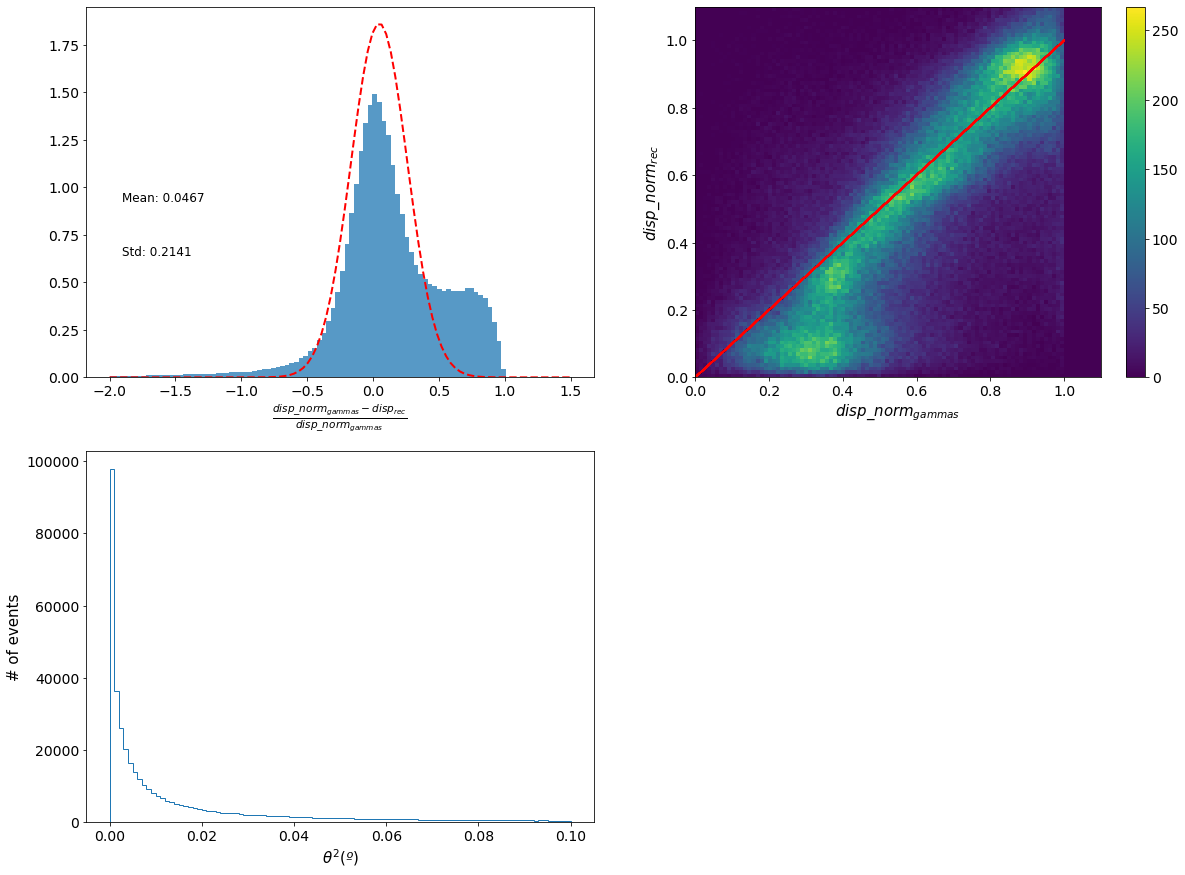

In [19]:
plt.rcParams['agg.path.chunksize'] = 10000   # sometimes complains and it needs this
plot_dl2.plot_disp(test_dl2)

## Source position in camera coordinates

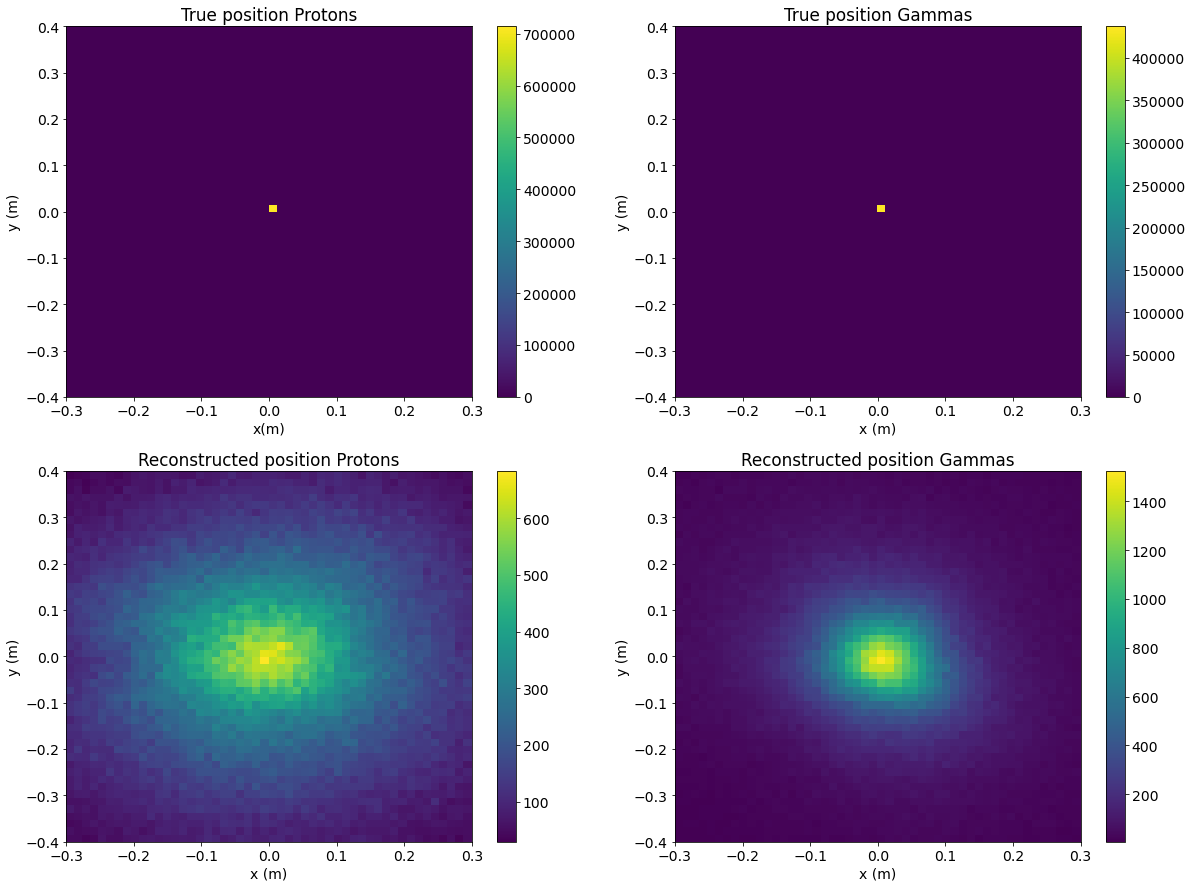

In [20]:
plot_dl2.plot_pos(test_dl2)

## Importance of features for Gamma/Hadron separation

<AxesSubplot:title={'center':'Feature importances (gini index)'}>

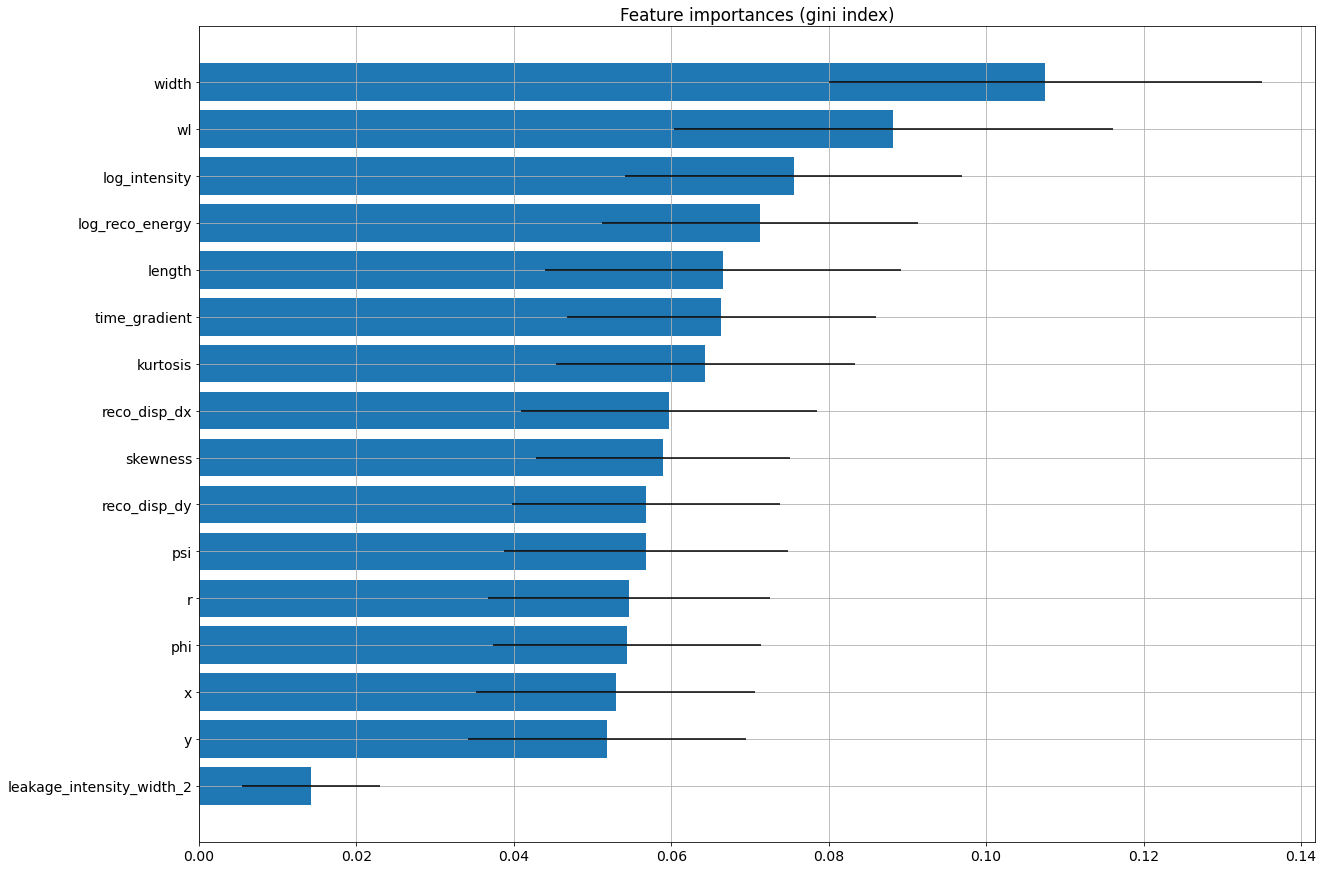

In [21]:
plot_dl2.plot_importances(RFcls_GH,features_sep)

## ROC curve

<AxesSubplot:title={'center':'gamma ROC curve'}, xlabel='gamma false positive rate', ylabel='gamma true positive rate'>

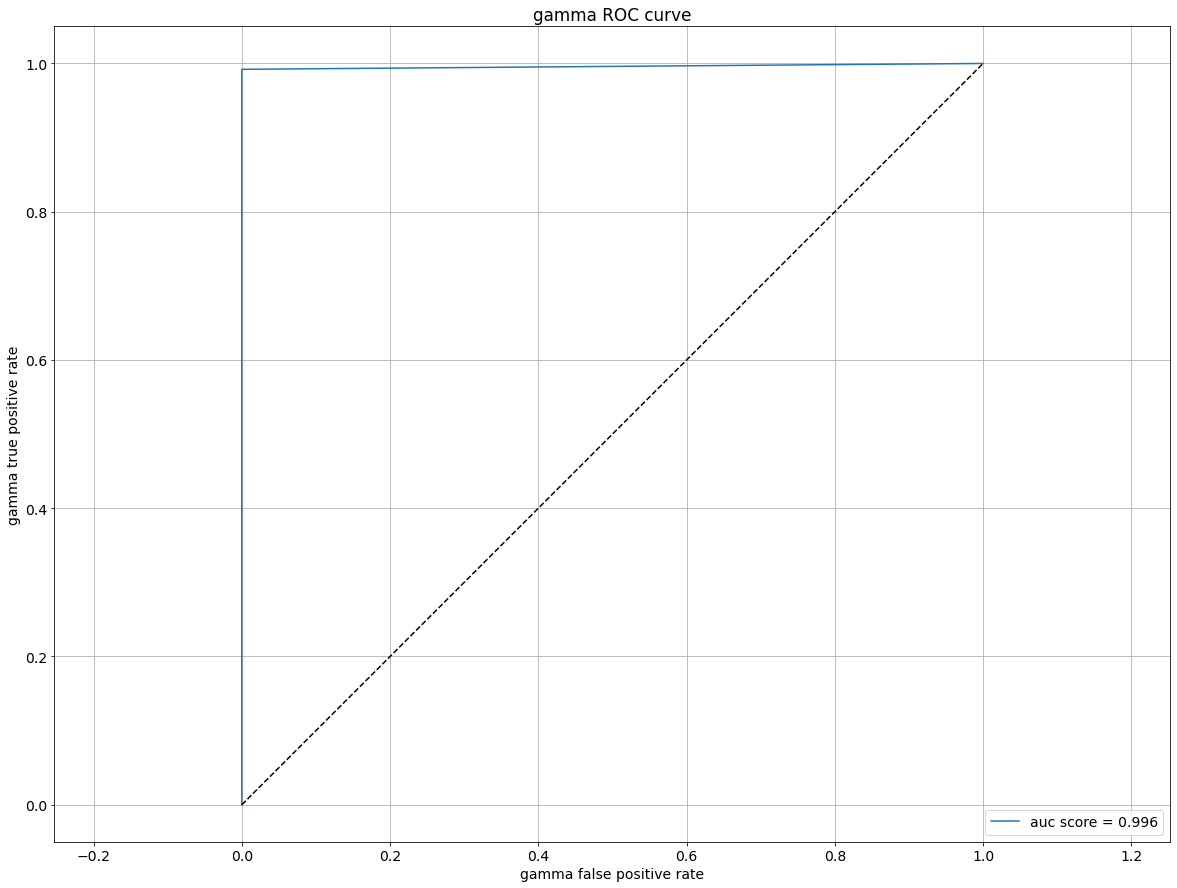

In [22]:
plot_dl2.plot_roc_gamma(test)


# Note on mono analysis

Mono analysis is very limited, specially at low energies, where it's much more difficult to separate gammas from hadrons without stereo information. If we discard low energy events, we can see that the performance improves.
<br>
<br>
For example, we can cut at **500 GeV:**

In [23]:
cut = 0.5 # TeV

e_cut = np.log10(cut) 
test_dl2_cut = test_dl2[test_dl2['log_reco_energy'] > e_cut]

<AxesSubplot:title={'center':'Energy resolution'}, xlabel='$E_R$ [TeV]', ylabel='$(\\Delta E/E)_{68}$'>

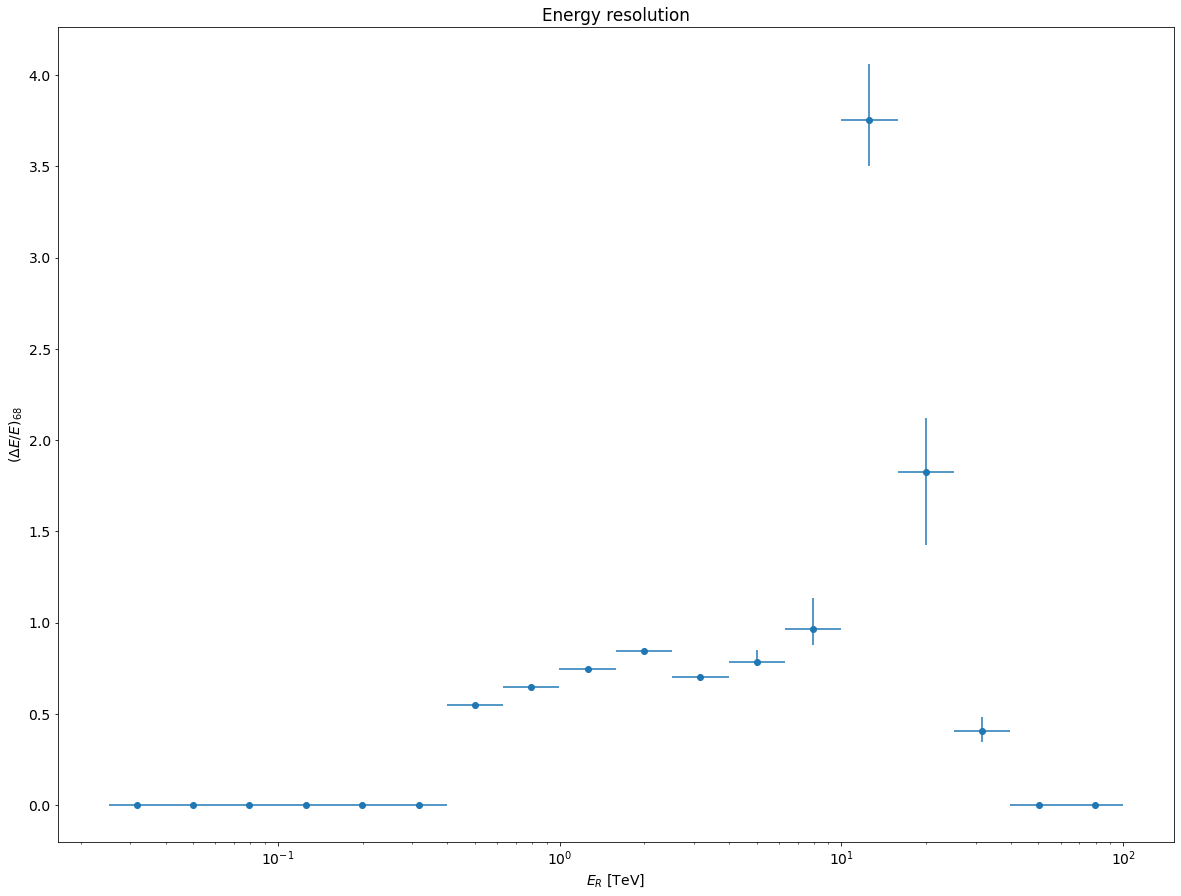

In [24]:
plot_dl2.plot_energy_resolution(test_dl2_cut)

mu = -0.03457225142125039
 sigma = 0.17144369198242185


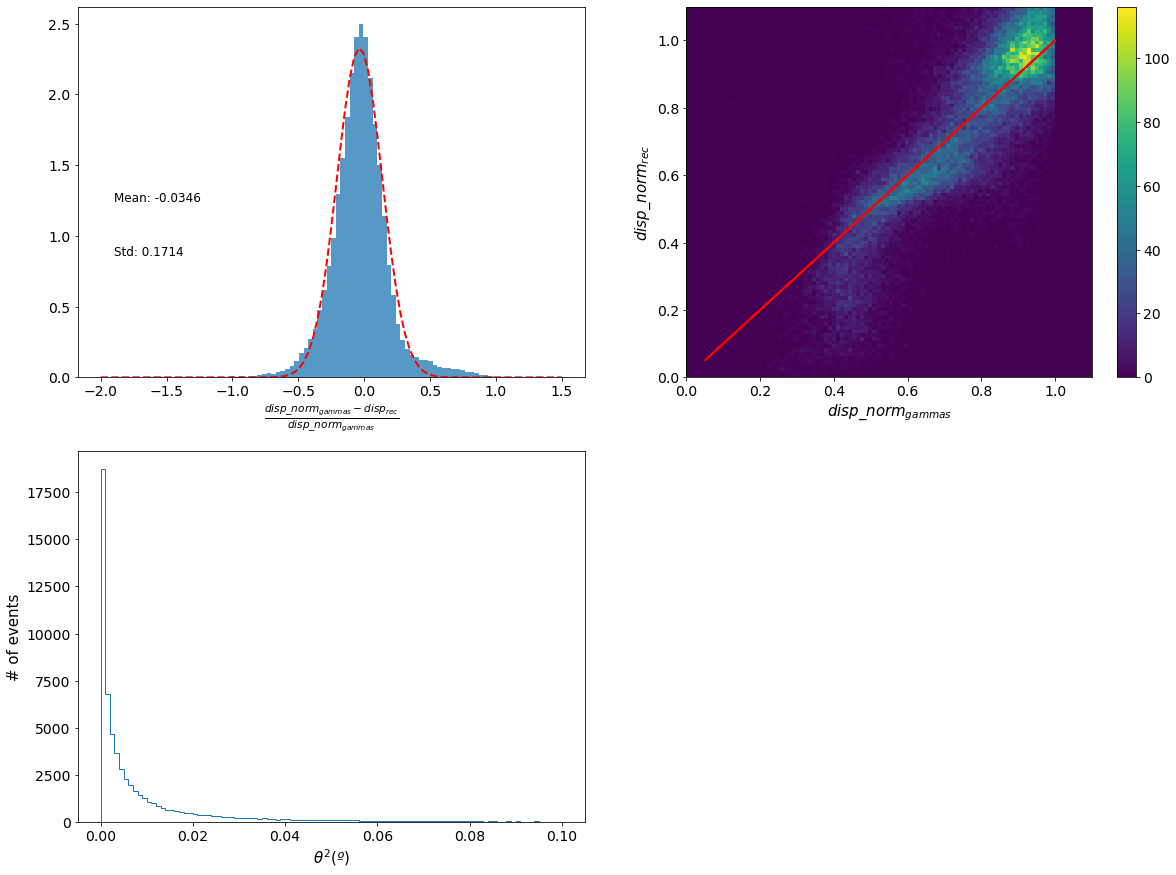

In [25]:
plot_dl2.plot_disp(test_dl2_cut)

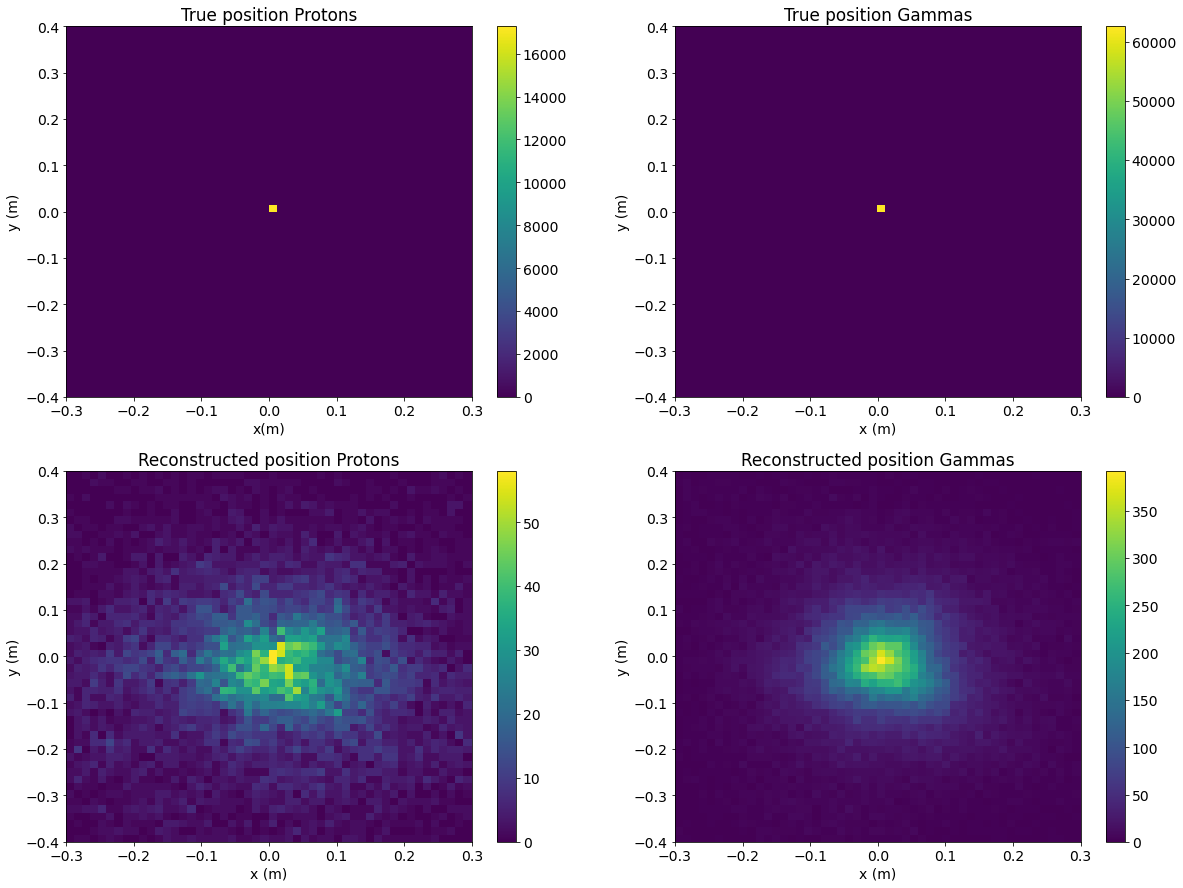

In [26]:
plot_dl2.plot_pos(test_dl2_cut)